## Importing Libraries

In [1]:
import os # to work with file system
from zipfile import ZipFile # to unzip
import shutil # to move files
import random # to generate random numbers
import numpy as np # to work with numpy arrays
import pandas as pd # to work with pandas
import matplotlib.pyplot as plt # to plot
import matplotlib.image as mpimg 
import tensorflow as tf # to implement deep learning model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, SpatialDropout2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator # to augment and read the files from directory
from tensorflow.keras.applications.inception_v3 import InceptionV3 # Pre trained Inception model
from tensorflow.keras import Model
from keras.preprocessing import image
from keras.models import load_model

## Extracting data from zipfile

In [2]:
def zip_extracter(source_path, dest_path):
    """ This function extracts the zip file from source path to dest path."""
    
    file_loc = source_path 

    zip_file = ZipFile(file_loc, 'r')
    zip_file.extractall(dest_path)#extracting
    zip_file.close()

In [2]:
data_dir = r'D:\Dogs_vs_Cats\dogs-vs-cats.zip' # Data directory
base_dir = r'C:\Users\14372\Desktop\College-2\AIES\final_project' # Working Directory

In [4]:
zip_extracter(data_dir, base_dir)

## List of directories after extracting

In [5]:
os.listdir(base_dir)

['sampleSubmission.csv', 'test1.zip', 'train.zip']

As we can see that there is more zip files, we have to unzip again!

In [6]:
zip_extracter(base_dir + '\\' + os.listdir(base_dir)[2], base_dir)

In [7]:
zip_extracter(base_dir + '\\' + os.listdir(base_dir)[1], base_dir)

## Training Instances

In [3]:
train_dir = base_dir + '\\train'

In [8]:
len(os.listdir(train_dir))

25000

## Testing Instances

In [4]:
test_dir = base_dir + '\\test1'

In [9]:
len(os.listdir(test_dir))

12500

## Making Directories

Tensorflow requires the data to be in the proper directories, so arranging according to it.

In [5]:
val_dir = base_dir + '\\val'

train_cat_dir = train_dir + '\\cat' # Directory of cats in trainig data
train_dog_dir = train_dir + '\\dog' # Directory of dogs in trainig data
val_cat_dir = val_dir + '\\cat' # Directory of cats in val data
val_dog_dir = val_dir + '\\dog' # Directory of dogs in val data

os.mkdir(train_cat_dir)
os.mkdir(train_dog_dir)
os.makedirs(val_cat_dir)
os.makedirs(val_dog_dir)

## To seperate the cat and dog images from training and test dataset

In [11]:
def move_img(dirct):
    """This function move the images from trainig directory to training cat and dog directory"""
    
    for i_name in os.listdir(dirct):
        
        if '.jpg' in i_name:

            if 'cat' in i_name:
#                 print(i_name)
#                 print(dirct + '\\' + i_name)
                dest_dir = base_dir + '\\' + dirct.split('\\')[-1] + '\\' + 'cat'
#                 print(dest_dir + '\\' + i_name)
                shutil.move(dirct + '\\' + i_name, dest_dir + '\\' + i_name)

            else:
                dest_dir = base_dir + '\\' + dirct.split('\\')[-1] + '\\' + 'dog'
                shutil.move(dirct + '\\' + i_name, dest_dir + '\\' + i_name)

In [12]:
move_img(train_dir)

In [13]:
os.listdir(train_dir)data:image/pjpeg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+xzZtYEDjJ6e/6/XI46HNOd1jVndgqKCzMxAAUDLEkkAADkknAHJokcFeB9BnOB7cA5+vXp9Pyd/4LCfto6B+yD+yF40kGtS6d8RfixZ3vw68AW9jzqUb6xB5PiPXYDx9nXRtBlu/s97ki31i80kYPmcfK04OUo0qUW51ZJQik23KVlb9eySbeh4UY880k7Rb1k9ox6yfkld97LufHP7Zn/BeX4cfDHxbrXwv/Zq0zQ/iP4i0W9udI1T4gazdO/hC31S2Zo7iDw/Y2ktvJ4ghhmUwjVJ9R0/T5ZF86yj1KyeO4k/nk/aI/wCCpH7eer6//wAJJ4s+OetyQ3LLc6R4F8IzL4d0LTVYs8Et1ZeEp9MjtxANsgm1PWr+62siOksglRPzp+AH7Ovxt/ao+MGtaD8JrCPUbbRjYa34o1rVtSksfDejjVHL21pqt3F5d3fanetBdKtlYokdslrPCsMawTzV+y1x/wAEiPjT46stItfGfxT0TwXpllFHBc2Xh221jUmjgTGILK41TVprKMxO0jwxJpj2yoQBKhJK9GNz7gbhmrUoZvmmC+vwpxnXw86VTG4mHPFTgnhqNKtGgpJqUHKMJOEovn5Wm/sMu4S4izOlQr5VldSeHqOUIYupWw+Gp1Gpck5RqVqtKpUipJxkqXPCMoyjyNxaXAfAz/g42/ax+GbaXpPxI0jwn8SdNgSGFZtX1q7sdWnhSRFLJqjQzRyM0QZC0kRVjtZyX+U/2BfsH/tu+Df24PgxpvxW8NWEmkTtdyaXrmhzFGn0bWIBKLmymdJZY5AjwymKYMFnt/KuFVTIY1/jg8f/APBBvwzZW9w/hr47a5e+IifP83X/AA/YC1ldsZjl+w3UcpVVwPNTp9/ys4VfliLxR+2F/wAEqfF+l6B4X+L3iHSfCmuC21WzXRNSvofCWtarBElrqFtd6SXe0uL5LG2hVGurUsbO2Qbz5bGDxcv4i4N4txH1PhrMqUMwUpzWFr0sZhlWjCPNKMYV6XKnZOS9krpRd1yrTozzgjiPJsE8fmWWuOFXs+bE4eeGrKnzzjBOapVOdRvKKcpxjG7T5ruz/wBKjcu4DPBBx6nHXP48D/OY5CuCMZxznt/k+n/1q/HH/glT/wAFH7b9tDwJJpHi8WVj8TtAt9POpRWkpFpq+nXcLi01ewilkklUzTQS/aYnJkjNxbMco2yD9iydwxgYxjv0qa1GpCpVp1IezqUZ+zqU3q1JW25d007xezUrrc+OlBwcYvVOMXGSW8Xs0t/lvdWNeWQD1z+GBnv+f1/Cv4rP+Dqnxndf8LT/AGUvAS3cqWn/AAgvjPxReRh28q0t5/Eum2Mt0sJUpNPcf2THCijJ328QJRmiZf7R5GwOnGfxx/Xn+WRX8w3/AAcKfs523jy6+DXxek8ERfEC5h8G+J/g7pejXniDUvC2n2Ov+MfFnhe38N61c6tpD/b7yew1jWYJrPw7DHEurCG7a41G0trN7XUfYwWKw+DxmGr4qap0lVVNTk7RVXERlh6HNJ2UVKtVhHmbSi2m3ZG+DweJxuJlhsLSlWrvD4iqqcbOUqeFozxddxV1zONCjUmoq7ly2SbaT+L/APglL8PtI/Z3/Zc8M+LvH3iLw1oev/GPUrz4gXNxq+p2OntPYalIsOgQrcXtxAZFfSktr8Qc+TPqjrIiTvJv/bm3vLPxR4ftb3Tde0fUtPuYbd7eWwvbW5jkSUjY8csDyLJkEAspOeqq2AB/OFqP7Nt94k+Cvww1jxd4atvHHiu4+FHh2O/OvXQh8P6Fbjw5aTaT4I8G6BpMFtNayaXMZ9Ne6v8AVo5zeW6XV7f+ZcSzW/mXwi+GP7Rv7Lun6T4s+GfgfULyx8e+L/Cvgq0+Gkl7rfh7VtW8R+LoZMLofiPWmuY0t/DmoxuNRu9Vs9S06fSLa+1GLVraysF3/h+d8I4HNK2d5zT4kwmIzfHZhiIVMHXqUsFgXUdWUFRoYqvXU4U6MIKNKpiqVCnKlBTn7GCcl/TGS5vjMOsry6rkeNwmU4DLsPUp5msPVxVR04QpKLlSo0nSqV6spKdWjha1esnNuMas7xf71fFjWfD3gJ7vUfFfj7wr4c022aKOS41zXtM0mJGkjaVY5Jby5hUyCNGfGRuRXJOAa/C//grL4n8B+KPgn4T8WeGdd0Dxevh34h+HrXUrrw5rNjqSwWOt2+oIovJLNrgpb3+wQx5aNJGlVlZzEwHj+q/Dn40/ta3HxF8a/GXw1daZrHwm8T6p4XHw5F9f6lbSeIdIvrbSbqO58SLNDpFzcvEL66Yf2TZ6aNNtLdo9Ru5dWhtIqnxs/Yq1a3/ZW+Kmv6RPpegPofh6HXtY0m00nTJND1XT9H1PQ70HRLq007RNS0jWk1C1LM93FqMdxDEWNu5uWWujgzg7LeHc0yTMp57SebTx+Fc8FSrYXEYenKvOnGNKNbD1alWopU6qiq0YuheTfPywlIri7iDGZhlmdYBZVXllMcsrRp5hPC4rByrSlQqvn9niKNKnBxq0byoOft4w5eaEXUij0T/ggP8AE25u/wBtnwDoOhvNaQJoeo28gSVxBe+H9O0HVm1aW8gG+NpZZ7PR7pQVHlXCxbJflk8z/QTsr6G7iDIwORzj9f1/Kv4Wf+Ddz9nW00rWvij+0fqml6qqeHdWl+HHwt1ua5UadrFjqUJv/E2oJA1rDLd3lhYNoGnfbo/IsRJf6nbpbPPExtv7TPA+rSz28RZicgZBPZvb6A5xzX6jm+PpVc3xcIPmSjQjNrZVeSN7baq6jJSs1O8WtLP+cK+HmqNByi4ypxmrK0rpVZbtN30aaa0a1W+ns7sTx+fTtnr7k8+pP5V+VX/BW3TLfVfgh8I0uCIhY/tG/DHVYLhgpjW50ptXv1tpclSPtkEFxDb7SQNQ+x7lbAFfqgT1POOvc/5+pr86/wDgqf4E1nxr+xd8UdR8Ms//AAlPw0TTvir4dhTcftl74ImbUbqwdF5cX+lPqNtD1CXLwS7XEZRtasHiKNXD3jF1oOnGUl7qlJcsZS0ulGVpNrZK/RE5bXjg81wGLm5KFDFUas+RtS5Izj7SKs7+9G66Xva9rn5x+HtL0bwVZ6pqGn+NtL8K6PNLqGsz6P4u0G28T6DZ3+qTT6jfHSymreG9ZsY73Ubme6eyl1660+3edotNs7K2CW68q/jj4b+G/GngPx38bPib4f8AEsVhcXg8FaZ4fg8N+FvB3g7UbvS9Rsr3xBc2N/4v1zXNS8VXOg3d/oOm3K6jqMdjY6pqthp+j2lxql3c3f4W/tuftNaN+0h+zV8PNO+Gfiaa213VfFXhOXxVpELv5mnDyL21vzqUaMrC007UxFOyuhM8kUTbPK3EfRHg7/gl5+z7B4O8I6n4w+LXxQ1vRLSC31i9+x6Xaalp2r3kthbyXFxbQ2WhzX1rbXcUccItA0U0Vo81tJc3chklk/GqPDNGhhKFTirNa2U4vMMZmOE+rQyOnXxc44WMKU5VcxvTqxnX5+SLlzKtRnV56lSMpJf1eszeIxE6OQ5fQzHDUMFgK/1upm06GGVXFubpww+FpUMTzexjT9tNpxdOoqcYQg+Xm+krn9qr4DwfHL4m3HwZ+I/hPwzYX2tC9+Kmn/EjwxY6x4SvNX0/Sxo82v6BpKePfh94ytvFUcWkaZoWtxSed4fvLfT4ry304aot7e6h2Pxt1yH4m/ArxvqP/Cxfh14y8E6t4J1rUdHg+Hfgq78OaXqt3Bp09zp7atqereOPG81xZWV7bW9+ljp66MzX1nAl/cXdos1hJ+OX7afwL/Zca88Y+MPDet/Eiz8WTm9k1hrTQbnS/C6apAkMMtzdz3ug2dza3t3JOkksiSXcupXTJNPdxyTtcP8APHwV/abvPC/7MX/CgtDmv9b8d+ONd1Xw34ctI45WuZB4mu7XRtNjEZdkzdCaedhHKh+2Ts0xEhIP0WG4Hbp5ZmfDmIx1WvhsZlmGxcMwyrCUpUqLot1q0cw5fbuOH9nBRm1S9nRdOMOR8iPJzPiTD4evjcrz+hl1ClLAY/F4fEYLNsVXWJrUcTD2FOpl9aEIQr4iNV3hCVSM6lOq5Rkudn9Zf/BKnQNHj/Yw/Z407w+ltBYWnhGU3ot0SEPrUmu6s+ts+0fvZG1Y3RaViXkABbHQfuR4J06O3giBYZCj3yfbgct/9ftX5W/sM/COP4G/Az4W/ClZnlm8IeF9Psr+c/8ALxrN2z6lrdxjapC3GrXt5NGpUFUdQ3zA5/VjwpE3lR7XcgIvO446Dj+ecf0zX0NL2dXE4ytS5qkKuNxE4Tk/enB1pShJpdXFpu11d32P55x0ZRhCMrJxpQi1HZOKjGVujV9tFe21j0/VNS03RbK51LWNRsdK020iea7v9Ru4LKytoUG6SW5urmSKGCNUBZnkdVUck4r85/jt/wAFB/2X7HSvE/w70fVP+Fwa5qdne+Hr/wAN+GluYdAu4r6zkivba48Z3No2gtGbN5Ezpc2qOZmSKRIkZ5ov5q/ix+0L8b/jTc6jN8VPiZ4q8VW1hqA1CXTLzUGttEisLjy5TBa6LYLb6XBFD5sHkLHaBlCH5idwrjJNYltbSO4thsvI4bPWy0Y/eGGVWs9SjTaAPMhbGwkgLje5AUmvullknBv2iVWUJOmop8kZOK5eZtJyWt2oqOjspXaa/qjhr6NWXYdwxHFGc1cwqRcZPA5ZF4XB3urwq4qopYqvC6al7GGCqW+GSep+Sn7fPw28Q/s3/tDeOriHws/hj4c/EfXpfF/hCDSruXUdBt0ur2SfVtBttSfT9PtpLrSri5kRrc2VvstJbSWKBUl2r9H/ALKP/BW/xb8DvDs+hazd2Hi7SYbpL0f28qyXtvF+5j+wRtMjk2kVvGkZfyw0rhoIvLlkmuW/Y7XfhD8Lv+Cgf7P2veAfFTR2/jLTLJUn1CCKG41fwv4hMEn9h+NNMtndDdaZqRUtPAJEhu4X1LR5ZoZEE6flLB/wQH8XRwXJ1b4v2EM6jES6fptxNY3wWQhJPMuPLvLIvEu+S0e2utsrAC9ZRXwC8R+Ecdga2Q+JGGo5fnuT13hcRGphsS3WdNJUcfg8Rh6dScYVIJSklKz92rC9KpFr8zzPgPivhXiHF0uF601heZ+0w9fEUVRoy5lfDVKWJmo1qdmqmFrrmbpTTc24ylPwz9uX/gotZftMhLTwrs0Dwrf6ZGNT023hjjN1di3muHSWWCFJBDHIkflKrlSoYf8ALTypI/8Agm94c8B+APGPhf8Aak/aI8L+LZ/AvhS8kT4ZNoel2N7a3XjZLKSZda1W0utT0/UG03TIY72fQZreC8s73XoyZ57ebT7GC++q/h7/AMEWND8EX0WreO/FjeK7awuRcWmivbLa6ZN5bLt+0wqhmvsBWG2aQW8uQHtTjI94/aL+G0Xgr4YaF4IgjtbFL68tH0vSbO3EMdno2kRXIjaOFQPKR724t1QBVUqtztyqNi8D4hcJVll3A/AdGpVo4+tGljcVGNenN4dr2mMqKrWSr1a0aMZynXqKKVOLh7zacfbyHw2zjibPaea8aY6jVqyap4fAYOqnKnCMX7/NSi6FClQgpVY06U6t6lpVPtxn+/8A+zB+0r8CPjI1kvg34haMdcv0imi8Ka1cJoPikq6b18rRNSa3ub9NoP8ApGli+tCQwW4Yo4H6qeGIlhiiwTjbg9fpzj/Jya/gu0zQBp2laK8LzxanFOb2C+hkNvdWbuItqW00b+dCVaJXVoWX987NjDtn7W+An7b37UHwInaXw342ute0S7nLXGi+Mlk8Q6ZdmE7XkCXkgurScsx8y5sri1nmwPOkcKAPqocPwwkb4SrKTi2/Z1kubV/ZqJKLsukox21b1Z9FxH9H3FVva1eHc6pufLzU8Dm1KUW5aScPr2Gi0tG1HnwiV7c9RJ3X/9k=

['cat', 'dog']

## To move some random images to validation directory for validation

In [14]:
def val_move_image(dirctr):
    """This function is used to move some random images from training set to validation set"""
    
    val_index = np.random.choice(
        np.arange(0,len(os.listdir(dirctr))),
        2500, replace = False).tolist() # to select random 2500 indexes
    
    val_imgs = np.array(os.listdir(dirctr))[val_index] # extracting the file names based on the index
    
    for img in val_imgs:
        
        dest_dir = val_dir + '\\' + dirctr.split('\\')[-1]
        shutil.move(dirctr + '\\' + img, dest_dir + '\\' + img) # moving images

In [15]:
val_move_image(train_cat_dir)# moving cat images 

In [16]:
val_move_image(train_dog_dir)# moving dog images 

## Data Visualisation

In [17]:
def plot_img(n_rows, n_cols, path1, path2):
    """This function is used to plot dog and cat images"""
    
    fig = plt.gcf()
    fig.set_size_inches(n_cols*4, n_rows*4) # to set image size
    
    index = int((n_rows*n_cols) / 2) # number of images from each path
    
    random_index = np.random.choice(len(os.listdir(path1)), index).tolist() # selecting index randomly
    random_fnames1 = np.array(os.listdir(path1))[random_index]
    random_fnames2 = np.array(os.listdir(path2))[random_index]
    img_path1 = [os.path.join(path1, fname) for fname in random_fnames1]
    img_path2 = [os.path.join(path2, fname) for fname in random_fnames2]
    
    for i, img in enumerate(img_path1 + img_path2): # to iterate over selected images
        
        sp = plt.subplot(n_rows, n_cols, i + 1) # to plot the images
        sp.axis('Off') 

        img = mpimg.imread(img)
        plt.imshow(img)

    plt.show()

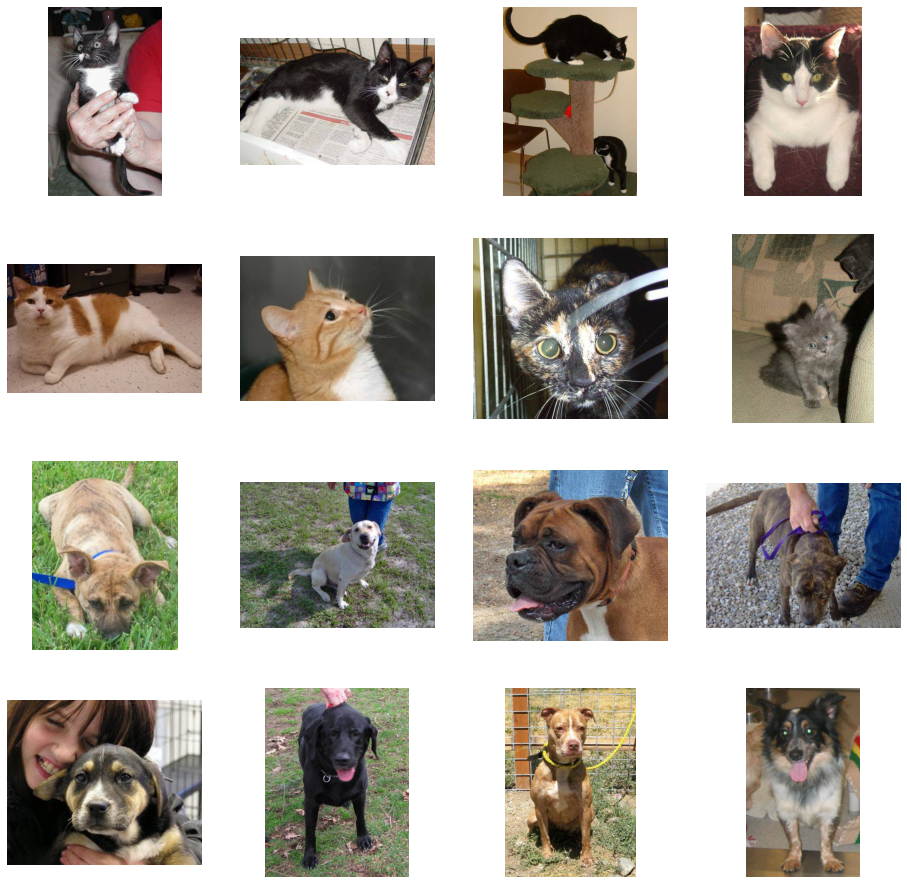

In [18]:
plot_img(4,4, train_cat_dir, train_dog_dir)

## Building the model from scratch

In [38]:
model = tf.keras.models.Sequential([
    
    # building a sequential model with input as (150, 150)
    Conv2D(16, (3,3), # 16 filters of size 3,3
           activation='relu', # RELU activation
           input_shape=(150, 150, 3)),
    MaxPooling2D(2,2), # Maxpooling layer to extract the dominant features
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2), 
    
    Conv2D(64, (3,3), activation='relu'), 
    MaxPooling2D(2,2),
    
    Flatten(), # flattening 
    
    Dense(512, activation='relu'), # Dense layer with 512 neurons

    Dense(1, activation='sigmoid')  # AS it is a binary classification
])

## Model Summary

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_376 (Conv2D)          (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_377 (Conv2D)          (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_378 (Conv2D)          (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18496)             0

## Compiling the model

In [41]:
model.compile(optimizer=Adam(learning_rate=0.001), # Adam optimizer
              loss='binary_crossentropy',
              metrics = ['accuracy'])

## Using ImageDataGenerator to read the data

In [42]:
train_datagen = ImageDataGenerator( rescale = 1.0/255. ) # Rescaling the images to get efficient and fast results
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# Using flow_from_directory method to read images from the directory
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=128,
                                                    class_mode='binary',
                                                    target_size=(150, 150))   

# Using flow_from_directory method to read images from the directory
validation_generator =  test_datagen.flow_from_directory(val_dir,
                                                         batch_size=128,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Implementing Callback 

To stop the model training as the model reaches 99% accuracy

In [43]:
class myCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}): # this method will be called everytime at the end of each epoch
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True
            
callback = myCallback()

## Training the model

In [44]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50, callbacks= [callback])

Epoch 1/50
157/157 [==============================] - 51s 295ms/step - loss: 0.6620 - accuracy: 0.6294 - val_loss: 0.5663 - val_accuracy: 0.7050
Epoch 2/50
157/157 [==============================] - 46s 291ms/step - loss: 0.5210 - accuracy: 0.7390 - val_loss: 0.5036 - val_accuracy: 0.7544
Epoch 3/50
157/157 [==============================] - 46s 291ms/step - loss: 0.4661 - accuracy: 0.7766 - val_loss: 0.5620 - val_accuracy: 0.7120
Epoch 4/50
157/157 [==============================] - 46s 290ms/step - loss: 0.4091 - accuracy: 0.8138 - val_loss: 0.4275 - val_accuracy: 0.7982
Epoch 5/50
157/157 [==============================] - 49s 313ms/step - loss: 0.3602 - accuracy: 0.8372 - val_loss: 0.4245 - val_accuracy: 0.8066
Epoch 6/50
157/157 [==============================] - 47s 299ms/step - loss: 0.3002 - accuracy: 0.8712 - val_loss: 0.4168 - val_accuracy: 0.8184
Epoch 7/50
157/157 [==============================] - 47s 297ms/step - loss: 0.2426 - accuracy: 0.8968 - val_loss: 0.4358 - val_ac

In [63]:
model.save(model_path)

## Model's Accuracy & Loss

In [28]:
def plot_acc_loss(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.show()

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

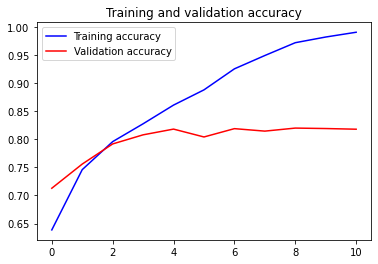

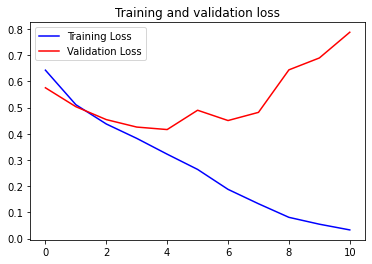

In [41]:
plot_acc_loss(history)

Observations:
1. Training Accuracy is increasing or training loss is decreasing with epochs, which means that model is learning
2. There is a huge difference between the trainig accuracy and validation accuracy which suggests that there is <b> overfitting</b>.

## Data Augmentation 

1. Data augmentation is a technique that can be used to genrate more images by using rotation, cropping, shifting, flipping, etc.
2. This will results in increase in the datasize and reduce in overfitting.

In [ ]:
train_datagen = ImageDataGenerator(# now it is also used for data augmentation
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255) # not applying to test set

train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  
        batch_size=128,
        class_mode='binary')# As this is binary classification

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=128,
        class_mode='binary')

## Training the new model with augmented data

In [88]:
model_2 = tf.keras.models.Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model_2.compile(loss='binary_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])

history_2 = model_2.fit(
      train_generator,
      epochs=50,
      validation_data=validation_generator, callbacks = [callback])

Epoch 1/50
157/157 [==============================] - 113s 710ms/step - loss: 0.6865 - accuracy: 0.5313 - val_loss: 0.6297 - val_accuracy: 0.6754
Epoch 2/50
157/157 [==============================] - 109s 697ms/step - loss: 0.6087 - accuracy: 0.6682 - val_loss: 0.5294 - val_accuracy: 0.7318
Epoch 3/50
157/157 [==============================] - 106s 677ms/step - loss: 0.5652 - accuracy: 0.7056 - val_loss: 0.5027 - val_accuracy: 0.7522
Epoch 4/50
157/157 [==============================] - 104s 663ms/step - loss: 0.5431 - accuracy: 0.7250 - val_loss: 0.4831 - val_accuracy: 0.7602
Epoch 5/50
157/157 [==============================] - 113s 719ms/step - loss: 0.5167 - accuracy: 0.7418 - val_loss: 0.4945 - val_accuracy: 0.7524
Epoch 6/50
157/157 [==============================] - 106s 678ms/step - loss: 0.4846 - accuracy: 0.7661 - val_loss: 0.4628 - val_accuracy: 0.7820
Epoch 7/50
157/157 [==============================] - 110s 701ms/step - loss: 0.4720 - accuracy: 0.7696 - val_loss: 0.4095 -

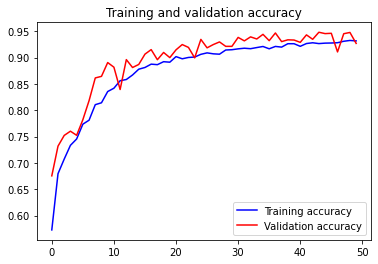

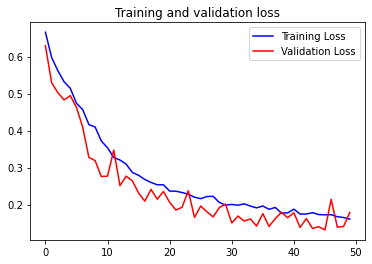

In [89]:
plot_acc_loss(history_2)

## Transfer learning

1. Transfer Learning is a method in which we use pre trained model, here we are using inception model. 
2. The top layer (input and output layer) is removed, and added according to this project.  
3. We are not training the inception layers, only the top layers will be trained.

In [20]:
# Pretrained Inception Model
inception = InceptionV3(input_shape = (150, 150, 3), # input image
                                include_top = False)# top layers are not included

for layer in inception.layers:# making layers of inception not traininable
    layer.trainable = False
    
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 74, 74, 32)   0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

## Using the 'mixed7' layer as the last layer of pre trained model

In [21]:
last_layer = inception.get_layer('mixed7') # Mixed 7 layer
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output # this layer is used as a last layer of this model

last layer output shape:  (None, 7, 7, 768)


## Adding Last layer as per the requirement of the project

In [22]:
x = Flatten()(last_output) # flattening
x = Dense(1024, activation='relu')(x) # Dense layers with 1024 neuraons
x = Dropout(0.2)(x) # Dropout layer to reduce overfitting                   
x = Dense  (1, activation='sigmoid')(x) # sigmoid layer           

model3 = Model( inception.input, x) 

model3.compile(optimizer = Adam(), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [23]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 128,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     


validation_generator =  test_datagen.flow_from_directory( val_dir,
                                                          batch_size  = 128,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Training the pre-trained model

In [18]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [24]:
history3 = model3.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 50, callbacks = [callback])

Epoch 1/50
157/157 [==============================] - 115s 715ms/step - loss: 0.3297 - accuracy: 0.9107 - val_loss: 0.0844 - val_accuracy: 0.9672
Epoch 2/50
157/157 [==============================] - 108s 686ms/step - loss: 0.1415 - accuracy: 0.9410 - val_loss: 0.0963 - val_accuracy: 0.9596
Epoch 3/50
157/157 [==============================] - 114s 727ms/step - loss: 0.1362 - accuracy: 0.9422 - val_loss: 0.0875 - val_accuracy: 0.9630
Epoch 4/50
157/157 [==============================] - 109s 693ms/step - loss: 0.1310 - accuracy: 0.9459 - val_loss: 0.0848 - val_accuracy: 0.9676
Epoch 5/50
157/157 [==============================] - 108s 689ms/step - loss: 0.1266 - accuracy: 0.9488 - val_loss: 0.0757 - val_accuracy: 0.9714
Epoch 6/50
157/157 [==============================] - 108s 689ms/step - loss: 0.1242 - accuracy: 0.9492 - val_loss: 0.0766 - val_accuracy: 0.9714
Epoch 7/50
157/157 [==============================] - 108s 687ms/step - loss: 0.1208 - accuracy: 0.9485 - val_loss: 0.0775 -

In [26]:
model_path = r'C:\Users\14372\Desktop\College-2\AIES\final_project\inception_trained.h5'
model3.save(model_path)

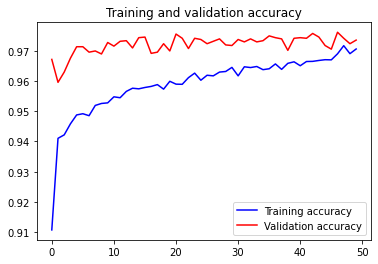

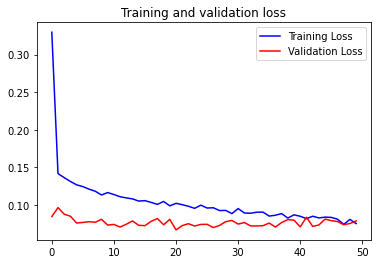

In [29]:
plot_acc_loss(history3)

In [30]:
model3 = load_model(model_path)

In [73]:
def predict_new_image(img_path, model_path):
    """This function outputs the class given for a path of the image and the model."""
    
    model = load_model(model_path)
    show_img = plt.imread(img_path)
    plt.imshow(show_img)
    img = image.load_img(img_path, target_size = (150, 150))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    prob = model.predict(x)
    
#     print(classes)
    
    if prob[0] > 0.5:
        print("It's a dog.")
    else:
        print("It's a cat.")
        
    plt.show()
    print('-'*20)
    
#     print(classes)

It's a cat.


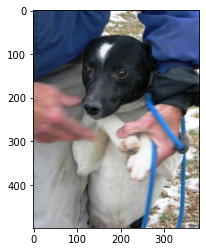

--------------------
It's a dog.


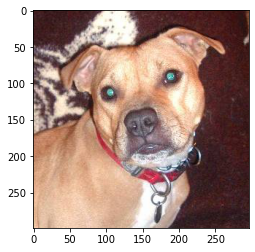

--------------------
It's a dog.


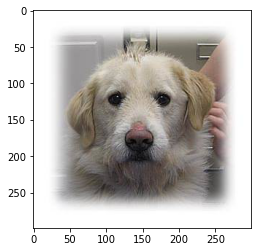

--------------------
It's a dog.


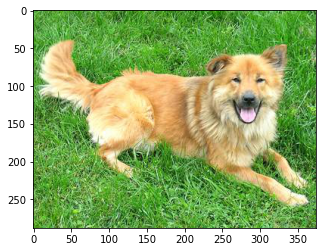

--------------------
It's a dog.


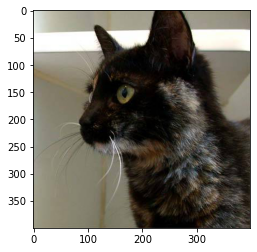

--------------------
It's a cat.


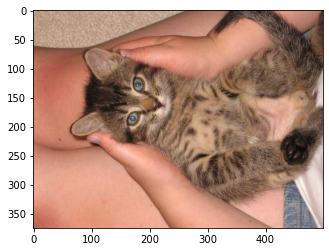

--------------------
It's a cat.


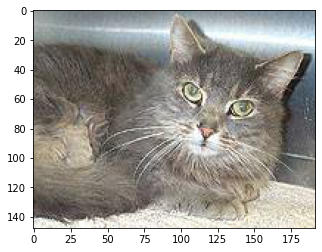

--------------------
It's a dog.


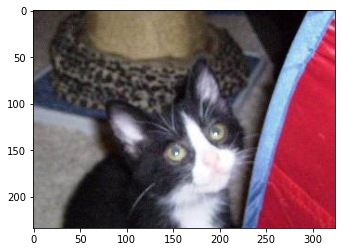

--------------------
It's a cat.


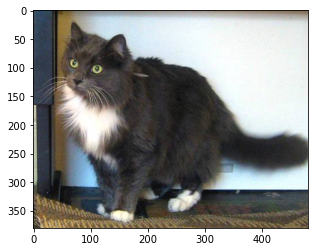

--------------------
It's a cat.


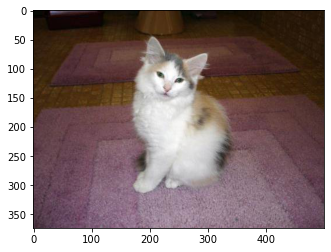

--------------------
It's a cat.


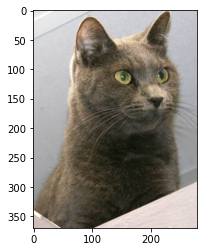

--------------------
It's a dog.


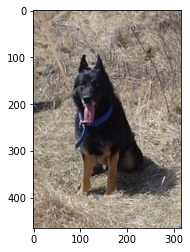

--------------------
It's a cat.


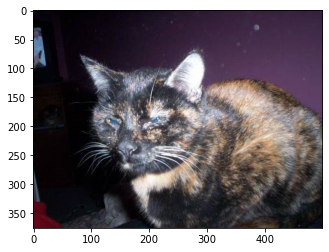

--------------------
It's a cat.


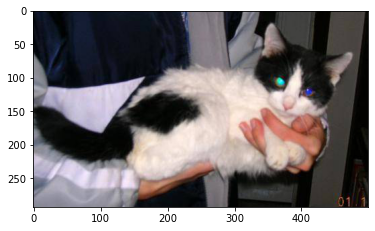

--------------------
It's a dog.


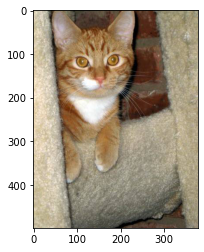

--------------------
It's a cat.


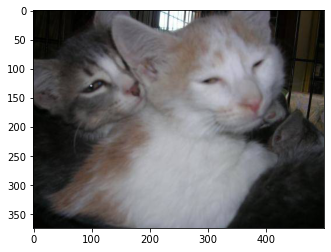

--------------------
It's a dog.


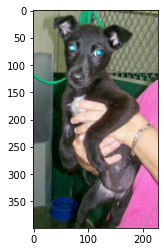

--------------------
It's a dog.


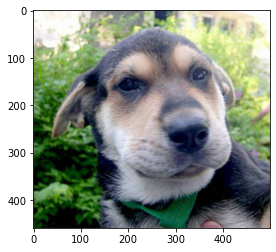

--------------------
It's a dog.


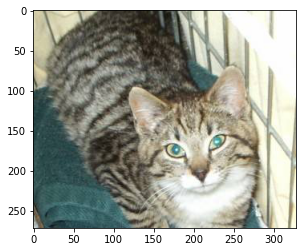

--------------------


In [74]:
for i in range(1,20):
    predict_new_image(r'C:\Users\14372\Desktop\College-2\AIES\final_project\test1\{}.jpg'.format(i), model_path)

## Results and Discussion

1. Pre-trained overperform the model from scratch.
2. Overfitting has been reduced by using data augmentation and dropout.

In [71]:
import io
def predict_new_image(img_path, model_path):
    """This function outputs the class given for a path of the image and the model."""
    
    model = load_model(model_path)
    show_img = plt.imread(img_path)
    plt.imshow(show_img)
    
    f = open(img_path, "r")
    content = f.read()
    img = Image.open(io.BytesIO(content))
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    target_size = (150, 150)
    img = img.resize(target_size, 0)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    prob = model.predict(x)
    
#     print(classes)
    
    if prob[0] > 0.5:
        print("It's a dog.")
    else:
        print("It's a cat.")
        
    plt.show()
    print('-'*20)
    
#     print(classes)

In [ ]:
predict_new_image()